<a href="https://colab.research.google.com/github/Tahahaha7/Capstone_Project/blob/master/Capstone_Uber_Speed_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $$\text{CAPSTONE PROJECT}$$
### $$\text{Ambulance Response Time Optimization}$$

# $\text{Installing Dependencies}$

In [ ]:
%%capture
!apt install libspatialindex-dev
!pip install rtree
!pip install momepy
!pip install osmapi

In [ ]:
%%capture
!pip install -Iv osmnx==0.16.0

In [ ]:
# Importing packages

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator
import osmnx as ox
import geopandas
import momepy
%matplotlib inline
ox.config(use_cache=True, log_console=True)
weight = 'length'

ox.__version__

'0.16.0'

In [ ]:
pd.__version__

'1.1.5'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# changing the working directory
%cd /content/gdrive/My Drive/Capstone

/content/gdrive/My Drive/Capstone


# $\text{Extract the road network}$

In [ ]:
# Exrtact the entire road network of the city

%%time
road_network = ox.graph_from_place('London, UK', network_type='drive')
graph_nx = nx.relabel.convert_node_labels_to_integers(road_network)

CPU times: user 3min 35s, sys: 2.95 s, total: 3min 38s
Wall time: 4min 37s


In [ ]:
# Include all osm in London
# Check which network intersects with the other
# Leave only 

print(nx.info(graph_nx))

Name: 
Type: MultiDiGraph
Number of nodes: 126806
Number of edges: 297683
Average in degree:   2.3475
Average out degree:   2.3475


In [ ]:
list(graph_nx.nodes(data=True))[:10]

[(0, {'osmid': 78112, 'x': -0.1457924, 'y': 51.526976}),
 (1, {'osmid': 99936, 'x': -0.1527906, 'y': 51.5236106}),
 (2, {'osmid': 99937, 'x': -0.1520235, 'y': 51.5230177}),
 (3, {'osmid': 101818, 'x': -0.1481038, 'y': 51.5351787}),
 (4, {'osmid': 101831, 'x': -0.1470438, 'y': 51.5356116}),
 (5, {'osmid': 101839, 'x': -0.1526662, 'y': 51.5375133}),
 (6, {'osmid': 101842, 'x': -0.1626572, 'y': 51.5340544}),
 (7,
  {'highway': 'traffic_signals',
   'osmid': 101843,
   'x': -0.1636822,
   'y': 51.5349387}),
 (8, {'osmid': 101851, 'x': -0.1644641, 'y': 51.5344972}),
 (9, {'osmid': 101852, 'x': -0.1654554, 'y': 51.533708})]

In [ ]:
list(graph_nx.edges(data=True))[:3]

[(0,
  19214,
  {'access': 'permissive',
   'highway': 'unclassified',
   'length': 19.391,
   'name': 'Outer Circle',
   'oneway': False,
   'osmid': 129375498}),
 (0,
  19215,
  {'access': 'permissive',
   'highway': 'unclassified',
   'length': 63.845,
   'name': 'Outer Circle',
   'oneway': False,
   'osmid': 129375498}),
 (0,
  19215,
  {'access': 'permissive',
   'geometry': <shapely.geometry.linestring.LineString at 0x7f5d7b422f90>,
   'highway': 'residential',
   'length': 102.544,
   'maxspeed': '20 mph',
   'name': 'Cambridge Terrace',
   'oneway': True,
   'osmid': 4257258})]

In [ ]:
osm_nodes = pd.DataFrame([graph_nx.nodes(data=True)[node] for node in graph_nx.nodes])

In [ ]:
osm_nodes.head()

,y,x,osmid,highway,ref
0,51.526976,-0.145792,78112,NaN,NaN
1,51.523611,-0.152791,99936,NaN,NaN
2,51.523018,-0.152024,99937,NaN,NaN
3,51.535179,-0.148104,101818,NaN,NaN
4,51.535612,-0.147044,101831,NaN,NaN


In [ ]:
osm_edges = pd.DataFrame(graph_nx.edges(data=True), columns=['source_idx', 'target_idx', 'info'])

In [ ]:
osm_edges_info = pd.DataFrame(osm_edges['info'].values.tolist(), index=osm_edges.index)

In [ ]:
osm_edges_info.insert(0, 'target_idx', osm_edges.target_idx)
osm_edges_info.insert(0, 'source_idx', osm_edges.source_idx)

osm_edges_info.head()

,source_idx,target_idx,osmid,name,highway,access,oneway,length,maxspeed,geometry,lanes,ref,bridge,junction,tunnel,width,est_width,service,area
0,0,19214,129375498,Outer Circle,unclassified,permissive,False,19.391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,19215,129375498,Outer Circle,unclassified,permissive,False,63.845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,19215,4257258,Cambridge Terrace,residential,permissive,True,102.544,20 mph,"LINESTRING (-0.1457924 51.526976, -0.1455099 5...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,110827,204647016,York Terrace West,unclassified,permissive,False,15.832,20 mph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,110826,204647020,York Gate,unclassified,permissive,False,8.052,20 mph,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
osm_edges_info.isna().sum()

source_idx         0
target_idx         0
osmid              0
name           15995
highway            0
access        295994
oneway             0
length             0
maxspeed       95040
geometry      106222
lanes         270211
ref           251906
bridge        294896
junction      293979
tunnel        297188
width         297504
est_width     297663
service       297664
area          297674
dtype: int64

In [ ]:
osm_nodes.columns

Index(['y', 'x', 'osmid', 'highway', 'ref'], dtype='object')

In [ ]:
# Combine the node osm ids with the edge pandas 
# Output: an entire dataframe of all osm ids (nodes + edges)

osm_edges_final = pd.merge(osm_edges_info, 
                           osm_nodes.drop(columns=['highway', 'ref']).rename(columns={"y": "y_source", "x": "x_source", "osmid": "osmid_source"}),
                           how='inner',
                           left_on='source_idx',
                           right_on=osm_nodes.index)

osm_edges_final = pd.merge(osm_edges_final,
                           osm_nodes.drop(columns=['highway', 'ref']).rename(columns={"y": "y_target", "x": "x_traget", "osmid": "osmid_target"}),
                           how='inner',
                           left_on='target_idx',
                           right_on=osm_nodes.index)

In [ ]:
#osm_edges_final.to_csv('osm_edges_london.csv', index=False)

In [ ]:
# Map the source and the target with osm id instead of the idx from nx

osm_edges_final.isna().sum()

source_idx           0
target_idx           0
osmid                0
name             15995
highway              0
access          295994
oneway               0
length               0
maxspeed         95040
geometry        106222
lanes           270211
ref             251906
bridge          294896
junction        293979
tunnel          297188
width           297504
est_width       297663
service         297664
area            297674
y_source             0
x_source             0
osmid_source         0
y_target             0
x_traget             0
osmid_target         0
dtype: int64

In [ ]:
#list(graph_nx.edges)[1]
#graph_nx.get_edge_data(0, 19222)
#london_osm = nx.to_pandas_edgelist(graph_nx)

In [ ]:
#pd.DataFrame([list(graph_nx.edges(data=True))[1][2] for i in graph_nx.edges])

In [ ]:
#osm_nodes = pd.DataFrame([graph_nx.nodes(data=True)[i] for i in graph_nx.nodes])
#missing = list(set(list(Graph.nodes())) - set(osm_nodes.osmid))

In [ ]:
import osmapi
api = osmapi.OsmApi()

osm_nodes_2 = []

for idx, i in enumerate(missing):
  if idx%10**4 == 0: print(idx)
  try: 
    node = api.NodeGet(i)
    osm_nodes_2.append([i, node['lon'], node['lat']])
  except: pass

osm_nodes_2 = pd.DataFrame(osm_nodes_2, columns=['osmid', 'x', 'y'])

In [ ]:
osm_all_nodes = osm_nodes.append(osm_nodes_2)

len(set(list(Graph.nodes())) - set(osm_all_nodes.osmid))

In [ ]:
#osm_all_nodes.to_csv('osm_all_nodes.csv')

osm_all_nodes.head()

In [ ]:
%%time
path2 = nx.shortest_path(graph_nx, 1, 300, weight=weight)

CPU times: user 313 ms, sys: 1.95 ms, total: 315 ms
Wall time: 319 ms


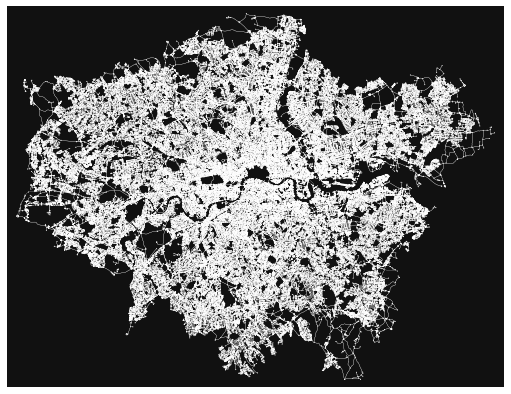

In [ ]:
fig, ax = ox.plot_graph(road_network, node_size=1, edge_color='w', edge_linewidth=0.2, figsize=(10, 7))

In [ ]:
#list_osmid_node_nx = [graph_nx.nodes(data=True)[i]['osmid'] for i in range(len(graph_nx.nodes(data=True)))]
#list_osmid_node_nx = [graph_nx.nodes[node]['osmid'] for node in graph_nx.nodes]

In [ ]:
#list_osmid_edge_nx = [list(graph_nx.edges(data=True))[i][2]['osmid'] for i in range(len(graph_nx.edges(data=True)))]
#list_osmid_edge_nx = [graph_nx.edges[edge]['osmid'] for edge in graph_nx.edges]

In [ ]:
def flatten(L):
    for item in L:
        try: yield from flatten(item)
        except TypeError: yield item

#list_osmid_edge_nx = list(flatten(list_osmid_edge_nx))

In [ ]:
#len(np.unique(list_osmid_edge_nx))
#any(isinstance(i, list) for i in list_osmid_edge_nx) # Check if the list is nested

In [ ]:
# READY TO GO ROAD NETWORK

osm_edges_final = pd.DataFrame('osm_edges_london.csv')

# $\text{Extract Uber Speed Data}$

In [ ]:
%%time
speed_data = pd.read_csv('/content/gdrive/My Drive/Capstone/movement-speeds-quarterly-by-hod-london-2019-Q1.csv')

CPU times: user 11 s, sys: 875 ms, total: 11.9 s
Wall time: 20.7 s


In [ ]:
speed_data.head()

,year,quarter,hour_of_day,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_mph_mean,speed_mph_stddev,speed_mph_p50,speed_mph_p85
0,2019,1,15,a2720e14e822d3f1a720d2b30322cd7e1e271f43,357044b95c67d9fd9b3d1bb79186cc7caf8b7731,eb5c82102d283c44346a230cd3028af48f05bde8,4973997,32959414,32959411,17.373,2.408,17.374,18.206
1,2019,1,16,a2720e14e822d3f1a720d2b30322cd7e1e271f43,357044b95c67d9fd9b3d1bb79186cc7caf8b7731,eb5c82102d283c44346a230cd3028af48f05bde8,4973997,32959414,32959411,16.990,3.876,17.001,20.037
2,2019,1,9,b25a11434171c057e152d9d58a777135fef8dfdc,41beb52c7f39892fb21ba15b3f8f5f76c67f49a2,eb5c82102d283c44346a230cd3028af48f05bde8,4973997,32959412,32959411,16.608,2.476,15.657,19.377
3,2019,1,9,4e2ad9364f64a9d01c7fc107200fd0cc65c2f836,b004f14939be1039448131ae4826363f26f81dac,000362c5b52f684344dd10095b91e7be3a5afed4,147247974,6504105337,1604745704,19.777,3.785,19.930,23.916
4,2019,1,13,4e2ad9364f64a9d01c7fc107200fd0cc65c2f836,b004f14939be1039448131ae4826363f26f81dac,000362c5b52f684344dd10095b91e7be3a5afed4,147247974,6504105337,1604745704,20.072,4.390,20.673,22.454


In [ ]:
print('Size of the dataset {} rows'.format(len(speed_data)))
print('Number of unique road ids {}'.format(len(np.unique(speed_data.osm_way_id))))
print('Average of the datapoints {}'.format(len(speed_data)/len(np.unique(speed_data.osm_way_id))))

Size of the dataset 5662264 rows
Number of unique road ids 90737
Average of the datapoints 62.40303294135799


In [ ]:
combine_nodes = list(set(speed_data.osm_start_node_id) | set(speed_data.osm_end_node_id))

len(combine_nodes), len(list_osmid_node_nx)
#len(np.unique(speed_data.osm_start_node_id)), len(np.unique(speed_data.osm_end_node_id))

(172077, 126806)

In [ ]:
#min(combine_nodes), max(combine_nodes), min(list_osmid_node_nx), max(list_osmid_node_nx)

min(list_osmid_edge_nx), max(list_osmid_edge_nx), min(speed_data.osm_way_id), max(speed_data.osm_way_id)

(74, 906305058, 73, 700437744)

In [ ]:
matched_nodes = list(set(combine_nodes) & set(list_osmid_node_nx))
len(matched_nodes)

64857

In [ ]:
list(graph_nx.nodes(data=True))[:20]

In [ ]:
list_osmid_edge_nx[:20]

In [ ]:
list(graph_nx.edges(data=True))[:10]

In [ ]:
#set(speed_data.osm_way_id).issubset(list_osmid_edge_nx)

matched_nodes = list(set(speed_data.osm_way_id) & set(list_osmid_edge_nx))
len(matched_nodes)

53318

In [ ]:
# print the map keeping only the nodes that appeared in both dataset

#final_graph = graph_nx.remove_nodes_from(to_remove)
#print(nx.info(final_graph))

190105

# $\text{Creating the Weighted Network}$

In [ ]:
#import pygeoj
#network = pygeoj.load(filepath="london_jan_2018.geojson")

In [ ]:
#network.all_attributes
#network.bbox

In [ ]:
filename_2019_Q1 = "london_2019_Q1.geojson"
filename_jan_2019 = "london_jan_2019.geojson"
#file = open(filename)

df = geopandas.read_file(filename_jan_2019)

In [ ]:
# Maybe narrow down the search for a subsection of London

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# Some problem with turning the data into df
#df = geopandas.GeoDataFrame(df, geometry = df.geometry)

In [ ]:
## Cross validate the Uber data with the OSM data then create the big network
## Check if the stations are include in either before dropping any node osm ids

## Output: A network that has all the attr from OSM and Uber

In [ ]:
len(df.osmwayid), df.osmwayid.nunique()

(1276006, 346603)

In [ ]:
len(df.osmwayid), len(osm_edges_final.osmid), len(set(df.osmwayid)), len(list(osm_edges_final.osmid))

(1276006, 297683, 346603, 297683)

In [ ]:
# Number of nested lists inside osmid

def count(l):
    return sum(1+count(i) for i in l if isinstance(i, list))

count(osm_edges_final.osmid)

27278

In [ ]:
# Get all Uber nodes into one list
uber_nodes = list(set(df.osmstartnodeid) | set(df.osmendnodeid))

# Get all OSM nodes into one list
osm_nodes = list(set(osm_edges_final.osmid_source) | set(osm_edges_final.osmid_target))

# Check how many are shared between Uber and OSM
matched_nodes = list(set(uber_nodes) & set(osm_nodes))

print('Uber nodes: {}\nOSM nodes: {}\nMatched nodes: {}'.format(len(uber_nodes), len(osm_nodes), len(matched_nodes)))

Uber nodes: 545665
OSM nodes: 126806
Matched nodes: 120768


In [ ]:
df.columns, osm_edges_final.columns

(Index(['osmname', 'osmstartnodeid', 'osmhighway', 'osmendnodeid', 'osmwayid',
        'speed_mean_mph', 'pct_from_freeflow', 'speed_freeflow_mph',
        'geometry'],
       dtype='object'),
 Index(['source_idx', 'target_idx', 'osmid', 'name', 'highway', 'access',
        'oneway', 'length', 'maxspeed', 'geometry', 'lanes', 'ref', 'bridge',
        'junction', 'tunnel', 'width', 'est_width', 'service', 'area',
        'y_source', 'x_source', 'osmid_source', 'y_target', 'x_traget',
        'osmid_target'],
       dtype='object'))

In [ ]:
# Uber unique pairs
uber_pairs = list(map(str, zip(df.osmstartnodeid, df.osmendnodeid)))

# OSM unique pairs
osm_pairs = list(map(str, zip(osm_edges_final.osmid_source, osm_edges_final.osmid_target)))

# Check how many are shared between Uber and OSM
matched_pairs = list(set(uber_pairs) & set(osm_pairs))

print('Uber pairs: {}\nOSM pairs: {}\nMatched pairs: {}'.format(len(uber_pairs), len(osm_pairs), len(matched_pairs)))

Uber pairs: 1276006
OSM pairs: 297683
Matched pairs: 225122


In [ ]:
# Merge Uber with osm from start to end

uber_osm = pd.merge(osm_edges_final, df,
                    how='left',
                    left_on=['osmid_source', 'osmid_target'], 
                    right_on = ['osmstartnodeid', 'osmendnodeid'])

In [ ]:
uber_osm.isna().sum()

source_idx                 0
target_idx                 0
osmid                      0
name                   12465
highway                    0
access                229409
oneway                     0
length                     0
maxspeed               77181
geometry_x            100318
lanes                 212281
ref                   199539
bridge                230295
junction              227326
tunnel                230349
width                 230332
est_width             230432
service               230433
area                  230436
y_source                   0
x_source                   0
osmid_source               0
y_target                   0
x_traget                   0
osmid_target               0
osmname                13146
osmstartnodeid             0
osmhighway                 0
osmendnodeid               0
osmwayid                   0
speed_mean_mph        157516
pct_from_freeflow     157516
speed_freeflow_mph    157516
geometry_y                 0
dtype: int64

In [ ]:
uber_osm = uber_osm.dropna(subset=['speed_mean_mph', 'pct_from_freeflow', 'speed_freeflow_mph'], how='all')

uber_osm.isna().sum()

source_idx                0
target_idx                0
osmid                     0
name                   2596
highway                   0
access                72692
oneway                    0
length                    0
maxspeed              13513
geometry_x            27884
lanes                 59747
ref                   42848
bridge                72806
junction              70328
tunnel                72912
width                 72874
est_width             72920
service               72925
area                  72922
y_source                  0
x_source                  0
osmid_source              0
y_target                  0
x_traget                  0
osmid_target              0
osmname                2582
osmstartnodeid            0
osmhighway                0
osmendnodeid              0
osmwayid                  0
speed_mean_mph            0
pct_from_freeflow         0
speed_freeflow_mph        0
geometry_y                0
dtype: int64

In [ ]:
uber_osm.columns

Index(['source_idx', 'target_idx', 'osmid', 'name', 'highway', 'access',
       'oneway', 'length', 'maxspeed', 'geometry_x', 'lanes', 'ref', 'bridge',
       'junction', 'tunnel', 'width', 'est_width', 'service', 'area',
       'y_source', 'x_source', 'osmid_source', 'y_target', 'x_traget',
       'osmid_target', 'osmname', 'osmstartnodeid', 'osmhighway',
       'osmendnodeid', 'osmwayid', 'speed_mean_mph', 'pct_from_freeflow',
       'speed_freeflow_mph', 'geometry_y'],
      dtype='object')

In [ ]:
#uber_osm.to_csv('uber_osm.csv', index=False)

In [ ]:
# Include the most important pieces to the network
uber_osm = uber_osm.rename(columns={'geometry_y':'geometry'})

Graph = nx.from_pandas_edgelist(uber_osm, source='osmstartnodeid', target='osmendnodeid', create_using=nx.MultiDiGraph(), 
                                edge_attr=['osmname', 'osmhighway', 'length', 'maxspeed', 'speed_mean_mph',  
                                           'pct_from_freeflow', 'speed_freeflow_mph', 'geometry'])

print(nx.info(Graph))

In [ ]:
#list(Graph.edges(data=True))[:3]
#list(Graph.nodes(data=True))[:5]

[(78112, {}), (25508583, {}), (103928, {}), (25508584, {}), (108200, {})]

In [ ]:
# Source nodes
dict_osm = {x: {'position': (y, z)} for x, y, z in zip(uber_osm.osmid_source, uber_osm.x_source, uber_osm.y_source)}
nx.set_node_attributes(Graph, dict_osm)

In [ ]:
# Target nodes
dict_osm = {x: {'position': (y, z)} for x, y, z in zip(uber_osm.osmid_target, uber_osm.x_traget, uber_osm.y_target)}
nx.set_node_attributes(Graph, dict_osm)

In [ ]:
list(Graph.nodes(data=True))[:5]

[(78112, {'position': (-0.1457924, 51.526976)}),
 (25508583, {'position': (-0.1457834, 51.5268017)}),
 (103928, {'position': (-0.145759, 51.5261069)}),
 (25508584, {'position': (-0.1458069, 51.5275501)}),
 (108200, {'position': (-0.1513038, 51.5238692)})]

In [ ]:
print(nx.info(Graph))

Name: 
Type: MultiDiGraph
Number of nodes: 113588
Number of edges: 230442
Average in degree:   2.0288
Average out degree:   2.0288


In [ ]:
%%time
path = nx.shortest_path(Graph, 27364362, 295679, weight='speed_mean_mph')

CPU times: user 16.4 s, sys: 838 ms, total: 17.3 s
Wall time: 17.3 s


In [ ]:
from shapely.geometry import Point

stations = pd.read_csv('final_stations.csv')
geometry = [Point(xy) for xy in zip(stations['lng'], stations['lat'])]
stations = geopandas.GeoDataFrame(stations, crs={'init': 'epsg:4326'}, geometry=geometry)

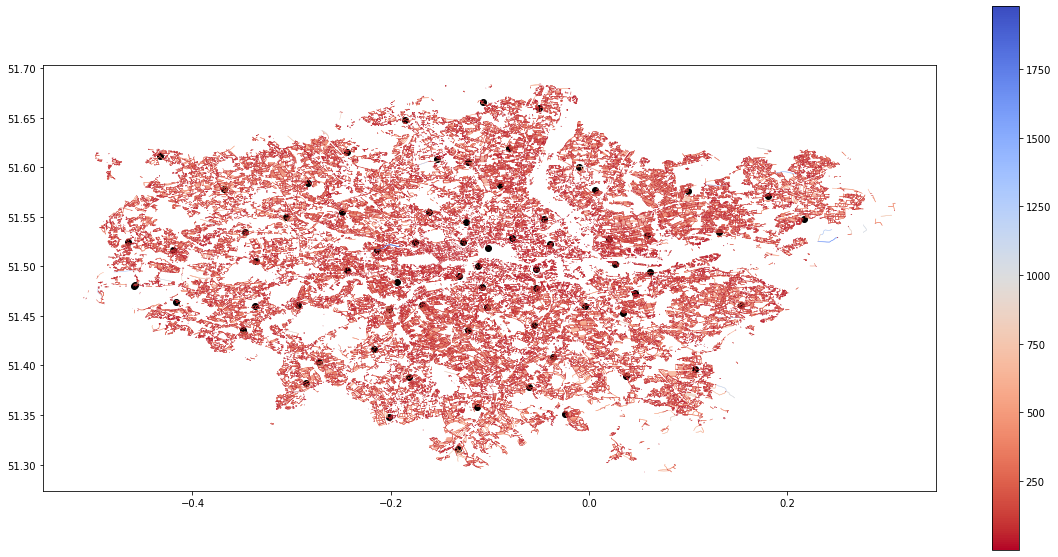

In [ ]:
base = stations.plot(color='k', figsize=(20, 10));
geopandas.GeoDataFrame(uber_osm).plot(ax=base, column='length', cmap='coolwarm_r', legend=True, linewidth=.5);

In [ ]:
# Relabeling nodes just to draw
Graph = nx.relabel_nodes(Graph, dict(zip(Graph.nodes, range(len(Graph.nodes)))))

In [ ]:
sorted(list(Graph.nodes(data=True)))[:5]

[(0, {'position': (-0.1457924, 51.526976)}),
 (1, {'position': (-0.1457834, 51.5268017)}),
 (2, {'position': (-0.145759, 51.5261069)}),
 (3, {'position': (-0.1458069, 51.5275501)}),
 (4, {'position': (-0.1513038, 51.5238692)})]

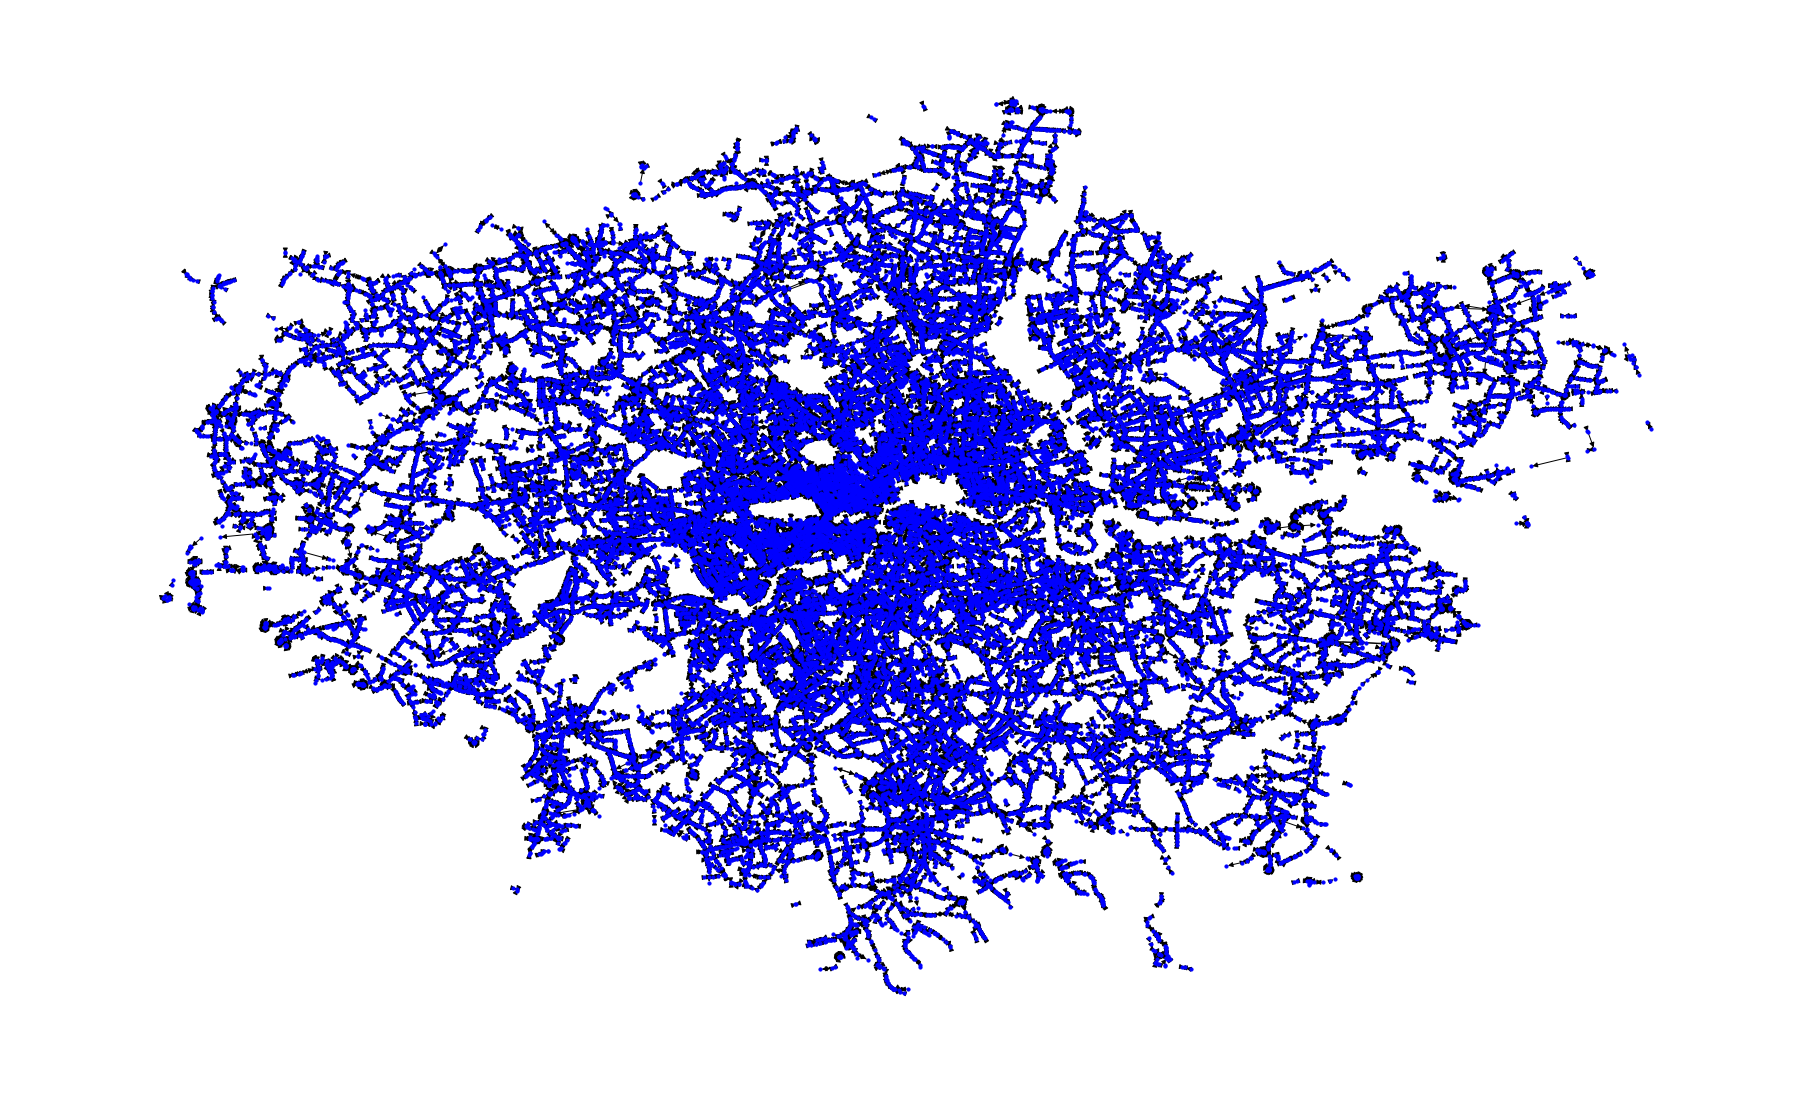

In [ ]:
plt.figure(figsize=(25, 15))
nx.draw(Graph, pos = [Graph.nodes[i]['position'] for i in Graph.nodes],
        node_size=10, node_color = 'blue', with_labels=False)
plt.show()

In [ ]:
#print(nx.is_weakly_connected(Graph))

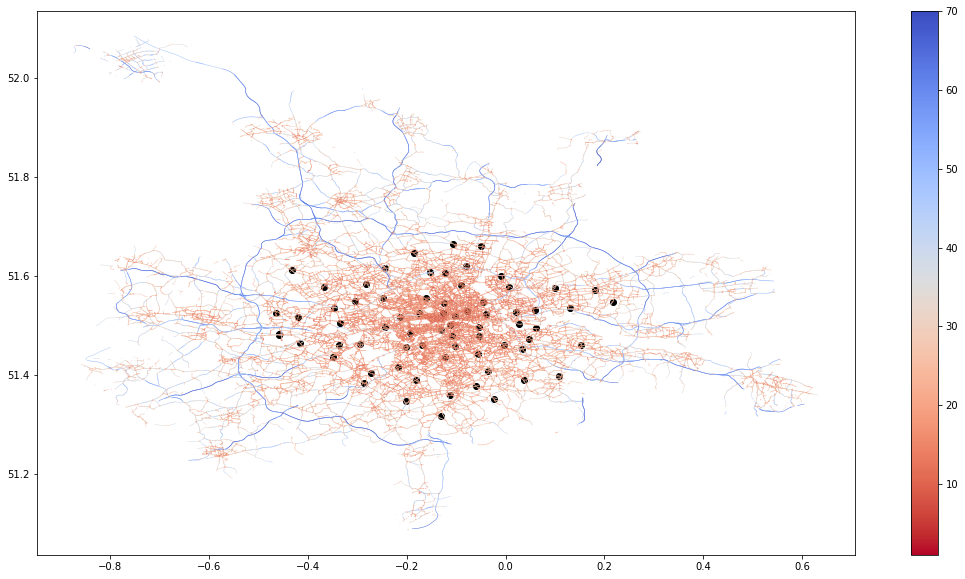

In [ ]:
base = stations.plot(color='k', figsize=(20, 10));
df.plot(ax=base, column='speed_mean_mph', cmap='coolwarm_r', legend=True, linewidth=.5);

In [ ]:
#stations.osm_id[0]

df_nodes = pd.DataFrame(list(Graph.nodes(data=True)))

df_nodes.values

array([[86113689, {'position': (-0.29086209999999996, 51.533662)}],
       [90081613, {'position': (0.016487900000000003, 51.475532)}],
       [90081659, {'position': (0.0166424, 51.4749279)}],
       ...,
       [91698920, {'position': (-0.38166809999999995, 51.4844567)}],
       [243081797, {'position': (-0.3113579, 51.486889899999994)}],
       [2329283778, {'position': (0.184303, 51.4741381)}]], dtype=object)

In [ ]:
# Are all ambulances part of OSM node ID in the network

#set(stations.osm_id).issubset(set(list(Graph.nodes(data=False))))

A = (df.osmendnodeid | df.osmstartnodeid).unique()
B = stations.osm_id

set(B).issubset(set(A))

False

# $\text{Hourly Data}$

In [ ]:
! npm i movement-data-toolkit -g

In [ ]:
! export NODE_OPTIONS="--max_old_space_size=8192" && mdt speeds-transform historical london 2018-01-01 2018-01-31 > london_jan_2018.csv

In [ ]:
# Only returned 100,000 rows of data but it included the day for each hour. I need more data
pd.read_csv('london_jan_2018.csv')